## 予測モデル作成（血液データあり）

In [13]:
# ライブラリのインポート
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score
from sklearn.utils import class_weight
from sklearn.ensemble import BaggingClassifier
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb  #lightGBMを入れる
import xgboost as xgb  #XGboostを入れる
from sklearn.linear_model import LogisticRegression  # ロジスティック回帰を入れる

import shap

# データの読み込み
df = pd.read_excel('【元データ】LightGBM分析データ_欠損値処理.xlsx')
df_lr = pd.read_excel('補完データ02_test03.xlsx') #　ロジスティック回帰のデータ読み込み

# カテゴリ変数のデータ型を変換
cat_cols = ['FBS', 'HbA1c', 'US', 'HbA1c_NGSP']
df[cat_cols] = df[cat_cols].astype(str)
df_lr[cat_cols] = df_lr[cat_cols].astype(str)


# ラベルエンコーディングを実行
le = LabelEncoder()
df[cat_cols] = df[cat_cols].apply(le.fit_transform)
df_lr[cat_cols] = df_lr[cat_cols].apply(le.fit_transform)



# 特徴量とターゲットに分割
X = df.drop('T2db', axis=1)
y = df['T2db']

X_lr = df_lr.drop('T2db', axis=1)
y_lr = df_lr['T2db']

# 特定の列を削除 
df = df.drop(['weight', 'Eating style3_midnight snack', 'One-year weight change'], axis=1)
df_lr = df_lr.drop(['weight', 'Eating style3_midnight snack', 'One-year weight change'], axis=1)

# 削除した結果を反映した特徴量を再作成
X = df.drop('T2db', axis=1)
X_lr = df_lr.drop('T2db', axis=1)

# アンダーサンプリング
rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(X, y)
X_resampled_lr, y_resampled_lr = rus.fit_resample(X_lr, y_lr)

# バギングによるモデルの学習と評価
# lightGBM
accuracy_scores = []
f1_scores = []
precision_scores = []  # 適合率を格納するリスト
confusion_matrices = []

# XGboost
accuracy_scores_xgb = []
f1_scores_xgb = []
precision_scores_xgb = []  # 適合率を格納するリスト
confusion_matrices_xgb = []

# ロジスティック回帰
accuracy_scores_lr = []
f1_scores_lr = []
precision_scores_lr = []  # 適合率を格納するリスト
confusion_matrices_lr = []
auc_scores_lr = []

n_estimators = 10  # バギングの回数

for _ in range(n_estimators):
    # 学習データとテストデータに分割
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, shuffle=True, stratify=y_resampled, random_state=0)
    print('X_trainの形状：', X_train.shape, ' y_trainの形状：', y_train.shape, ' X_testの形状：', X_test.shape, ' y_testの形状：', y_test.shape)
    
    # 学習データとテストデータに分割（ロジスティック回帰）
    X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X_resampled_lr, y_resampled_lr, test_size=0.3, shuffle=True, stratify=y_resampled, random_state=0)

    # LightGBM用のデータセットを作成
    lgb_train = lgb.Dataset(X_train, y_train)

    # xgboost用のデータセットを作成
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    # ハイパーパラメータの設定
    params = {
        'objective': 'binary',
        'num_leaves': 5,
        'seed': 0,
        'verbose': -1,
    }

    params_xgb = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'max_depth': 2,
        'learning_rate': 0.8,
        'base_score': 0.5,
        'min_split_loss': 0,
        'reg_lambda': 0,
        'reg_alpha': 0,
        'seed': 0,
    }

    # LightGBMモデルの学習
    model = lgb.train(params,
                      lgb_train,
                      num_boost_round=500,
                      valid_sets=[lgb_train],
                      valid_names=['train'],
                      early_stopping_rounds=20,
                      verbose_eval=False)

    # xgboostモデルの学習
    model_xgb = xgb.train(params_xgb,
                          dtrain,
                          num_boost_round=500,
                          early_stopping_rounds=20,
                          verbose_eval=False,
                          evals=[(dtest, 'test')])
    
    # ロジスティック回帰の学習
    model_lr = LogisticRegression()
    model_lr.fit(X_train_lr, y_train_lr)
    

    # テストデータの予測と評価(lightGBM)
    y_test_pred_proba = model.predict(X_test)  # ラベル1の確率
    y_test_pred = np.round(y_test_pred_proba)  # 確率をラベル0 or 1に変換
    ac_score = accuracy_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred)  # 適合率の計算

    # 混同行列(lightGBM)
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 20})
    plt.xlabel('pred')
    plt.ylabel('label')
    plt.savefig('confusion_matrix.png', dpi=300)
    plt.close()
    accuracy_scores.append(ac_score)
    f1_scores.append(f1)
    precision_scores.append(precision)  # 適合率
    confusion_matrices.append(cm)

    #テストデータの予測と評価(XGboost)
    y_test_pred_proba_xgb = model_xgb.predict(dtest)  # ラベル1の確率
    y_test_pred_xgb = np.round(y_test_pred_proba_xgb)  # 確率をラベル0 or 1に変換
    ac_score_xgb = accuracy_score(y_test, y_test_pred_xgb)
    f1_xgb = f1_score(y_test, y_test_pred_xgb)
    precision_xgb = precision_score(y_test, y_test_pred_xgb)  # 適合率の計算

    
    # 混同行列(XGboost)
    cm_xgb = confusion_matrix(y_test, y_test_pred_xgb)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 20})
    plt.xlabel('pred')
    plt.ylabel('label')
    plt.savefig('confusion_matrix_xgb.png', dpi=300)
    plt.close()
    accuracy_scores_xgb.append(ac_score_xgb)
    f1_scores_xgb.append(f1_xgb)
    precision_scores_xgb.append(precision_xgb)  # 適合率
    confusion_matrices_xgb.append(cm_xgb)
    
    
    #ロジスティック回帰による予測と評価
    y_test_pred_proba_lr = model.predict(X_test_lr)  # ラベル1の確率
    y_test_pred_lr = np.round(y_test_pred_proba_lr)  # 確率をラベル0 or 1に変換
    ac_score_lr = accuracy_score(y_test_lr, y_test_pred_lr)
    f1_lr = f1_score(y_test_lr, y_test_pred_lr)
    precision_lr = precision_score(y_test_lr, y_test_pred_lr)  # 適合率の計算

    # 混同行列(ロジスティック回帰)
    cm_lr = confusion_matrix(y_test_lr, y_test_pred_lr)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 20})
    plt.xlabel('pred')
    plt.ylabel('label')
    plt.savefig('confusion_matrix_lr.png', dpi=300)
    plt.close()
    accuracy_scores_lr.append(ac_score_lr)
    f1_scores_lr.append(f1_lr)
    precision_scores_lr.append(precision_lr)  # 適合率
    confusion_matrices_lr.append(cm_lr)
    

# 結果の表示
print('LightGBM accuracy = %.3f' % np.mean(accuracy_scores))
print('LightGBM F1-score = %.3f' % np.mean(f1_scores))
print('LightGBM Precision = %.3f' % np.mean(precision_scores))
# print('LightGBM AUC = %.2f' % np.mean(auc_scores))

print('XGboost accuracy = %.3f' % np.mean(accuracy_scores_xgb))
print('XGboost F1-score = %.3f' % np.mean(f1_scores_xgb))
print('XGboost Precision = %.3f' % np.mean(precision_scores_xgb))
# print('XGboost AUC = %.2f' % np.mean(auc_scores_xgb))

print('Logistic Regression accuracy = %.3f' % np.mean(accuracy_scores_lr))
print('Logistic Regression F1-score = %.3f' % np.mean(f1_scores_lr))
print('Logistic Regression Precision = %.3f' % np.mean(precision_scores_lr))
# print('Logistic Regression AUC = %.2f' % np.mean(auc_scores_lr))

X_trainの形状： (646, 40)  y_trainの形状： (646,)  X_testの形状： (278, 40)  y_testの形状： (278,)


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


X_trainの形状： (646, 40)  y_trainの形状： (646,)  X_testの形状： (278, 40)  y_testの形状： (278,)


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


X_trainの形状： (646, 40)  y_trainの形状： (646,)  X_testの形状： (278, 40)  y_testの形状： (278,)


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


X_trainの形状： (646, 40)  y_trainの形状： (646,)  X_testの形状： (278, 40)  y_testの形状： (278,)


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


X_trainの形状： (646, 40)  y_trainの形状： (646,)  X_testの形状： (278, 40)  y_testの形状： (278,)


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


X_trainの形状： (646, 40)  y_trainの形状： (646,)  X_testの形状： (278, 40)  y_testの形状： (278,)


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


X_trainの形状： (646, 40)  y_trainの形状： (646,)  X_testの形状： (278, 40)  y_testの形状： (278,)


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


X_trainの形状： (646, 40)  y_trainの形状： (646,)  X_testの形状： (278, 40)  y_testの形状： (278,)


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


X_trainの形状： (646, 40)  y_trainの形状： (646,)  X_testの形状： (278, 40)  y_testの形状： (278,)


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


X_trainの形状： (646, 40)  y_trainの形状： (646,)  X_testの形状： (278, 40)  y_testの形状： (278,)


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


LightGBM accuracy = 0.766
LightGBM F1-score = 0.760
LightGBM Precision = 0.780
XGboost accuracy = 0.763
XGboost F1-score = 0.759
XGboost Precision = 0.770
Logistic Regression accuracy = 0.680
Logistic Regression F1-score = 0.698
Logistic Regression Precision = 0.660


## ROC曲線作成

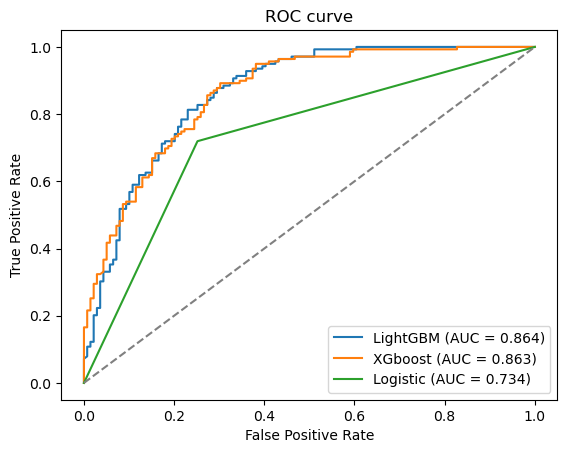

LightGBM AUCスコア = 0.864
XGboost AUCスコア = 0.863
Logistic AUCスコア = 0.734


In [14]:
#ライブラリをインポート
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, roc_curve, roc_auc_score


# テストデータの予測確率を取得
y_test_pred_proba_light = model.predict(X_test)
y_test_pred_proba_xgb = model_xgb.predict(dtest)  # dtestはXGboost用のデータセット
y_test_pred_proba_lr = model_lr.predict(X_test_lr)

# AUCスコアを計算
auc_score_light = roc_auc_score(y_test, y_test_pred_proba_light)
auc_score_xgb = roc_auc_score(y_test, y_test_pred_proba_xgb)
auc_score_lr = roc_auc_score(y_test_lr, y_test_pred_proba_lr)

# AUC曲線をプロット
# lightGBMの描写
fpr_light, tpr_light, _ = roc_curve(y_test, y_test_pred_proba_light)
plt.plot(fpr_light, tpr_light, label='LightGBM (AUC = {:.3f})'.format(auc_score_light))

# XGboostの描写
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_test_pred_proba_xgb)
plt.plot(fpr_xgb, tpr_xgb, label='XGboost (AUC = {:.3f})'.format(auc_score_xgb))

# ロジスティック回帰の描写
fpr_lr, tpr_lr, _ = roc_curve(y_test_lr, y_test_pred_proba_lr)
plt.plot(fpr_lr, tpr_lr, label='Logistic (AUC = {:.3f})'.format(auc_score_lr))

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend()

# 保存と表示
plt.savefig('roc_curve_notboold.png', dpi=300)
plt.show()

# AUCスコアを表示
print('LightGBM AUCスコア = {:.3f}'.format(auc_score_light))
print('XGboost AUCスコア = {:.3f}'.format(auc_score_xgb))
print('Logistic AUCスコア = {:.3f}'.format(auc_score_lr))

## 特徴量抽出（血液データあり）

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


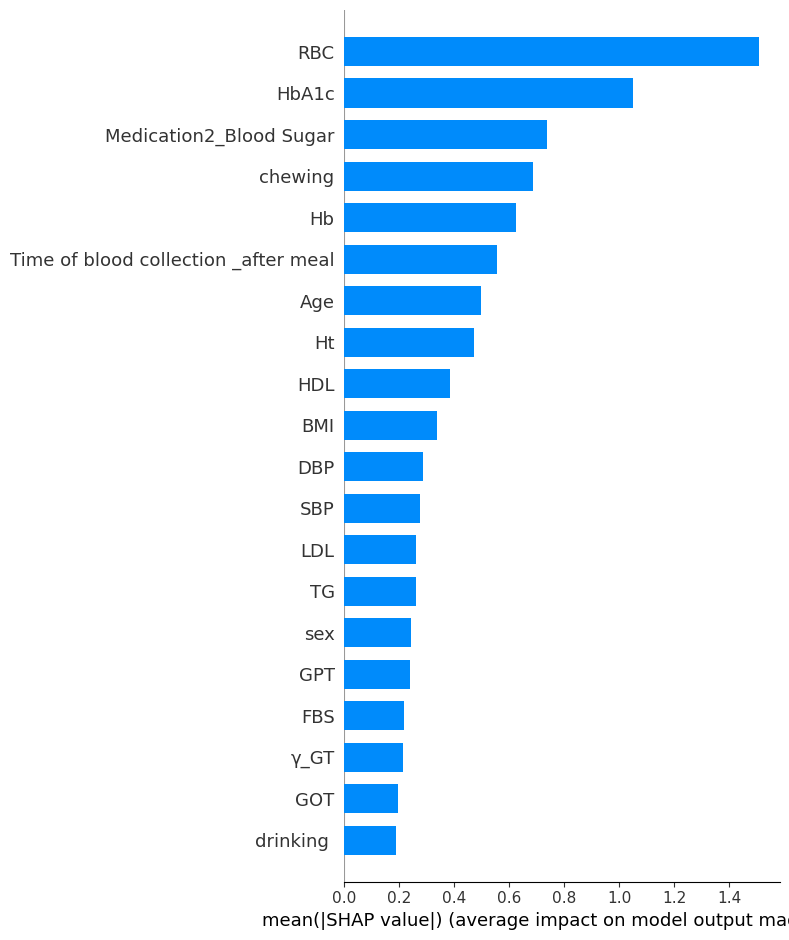

In [15]:
import shap

# SHAPの解釈子を作成
explainer = shap.TreeExplainer(model)

# テストデータのSHAP値を計算
shap_values = explainer.shap_values(X_test)

# SHAP summary plotを作成
shap.summary_plot(shap_values[1], X_test, feature_names=X_test.columns, plot_type="bar",show=False,)

# レイアウトの調整
plt.tight_layout()


# 保存
plt.savefig('summary_plot_lightgbm.png', dpi=300)


## 特徴量抽出_xgboost(血液データあり)

In [20]:
import xgboost as xgb
import shap

# XGBoostモデルを訓練またはロード
# ここでモデルを訓練またはロードするコードが入ります

# XGBoostモデル用のデータセットを作成
dtest = xgb.DMatrix(X_test, label=y_test)  # テストデータのX, yをXGBoostのDMatrixに変換

# SHAP用のTreeExplainerを作成
explainer_xgb = shap.TreeExplainer(model_xgb)  # model_xgbはあなたのXGBoostモデルです

# テストデータのSHAP値を計算
shap_values_xgb = explainer_xgb.shap_values(dtest)

# SHAP summary plotを作成
shap.summary_plot(shap_values_xgb[1], X_test, feature_names=X_test.columns, plot_type="bar", show=False)


AttributeError: module 'numpy' has no attribute 'int'.
`np.int` was a deprecated alias for the builtin `int`. To avoid this error in existing code, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

SyntaxError: invalid syntax (232156087.py, line 1)

In [ ]:
## 特徴量抽出_XGBoost(血液データあり)

In [28]:
import xgboost as xgb
import shap

# XGBoostモデルを構築
xgb_model = xgb.XGBClassifier()  # 実際のXGBoostモデルに置き換えてください
xgb_model.fit(X_train, y_train)

# XGBoostモデル用のTreeExplainerを作成
explainer_xgb = shap.TreeExplainer(xgb_model)

# テストデータのSHAP値を計算
shap_values_xgb = explainer_xgb.shap_values(X_test)

# SHAP summary plotを作成
shap.summary_plot(int(shap_values_xgb[1]), X_test, feature_names=X_test.columns, plot_type="bar", show=False)

# レイアウトの調整
plt.tight_layout()

# 保存
plt.savefig('summary_plot_xgboost.png', dpi=300)


AttributeError: module 'numpy' has no attribute 'int'.
`np.int` was a deprecated alias for the builtin `int`. To avoid this error in existing code, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

## 血液データ削除

In [2]:
# ライブラリのインポート
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score
from sklearn.utils import class_weight
from sklearn.ensemble import BaggingClassifier
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb  #lightGBMを入れる
import xgboost as xgb  #XGboostを入れる
from sklearn.linear_model import LogisticRegression  # ロジスティック回帰を入れる

import shap

# データの読み込み
df = pd.read_excel('【元データ】LightGBM分析データ_欠損値処理.xlsx')
df_lr = pd.read_excel('補完データ02_test03.xlsx') #　ロジスティック回帰のデータ読み込み

# カテゴリ変数のデータ型を変換
cat_cols = ['FBS', 'HbA1c', 'US', 'HbA1c_NGSP']
df[cat_cols] = df[cat_cols].astype(str)
df_lr[cat_cols] = df_lr[cat_cols].astype(str)


# ラベルエンコーディングを実行
le = LabelEncoder()
df[cat_cols] = df[cat_cols].apply(le.fit_transform)
df_lr[cat_cols] = df_lr[cat_cols].apply(le.fit_transform)


# 特徴量とターゲットに分割
X = df.drop('T2db', axis=1)
y = df['T2db']

X_lr = df_lr.drop('T2db', axis=1)
y_lr = df_lr['T2db']

# 特定の列を削除
df = df.drop(['weight', 'TG', 'HDL', 'LDL', 'GOT', 'GPT', 'γ_GT', 'Ht', 'Hb', 'RBC', 'chewing', 'Medication1_Blood Pressure', 'Time of blood collection _after meal', 'Medication2_Blood Sugar', 'Eating style3_midnight snack', 'One-year weight change', 'HbA1c', 'FBS', 'US', 'HbA1c_NGSP'], axis=1)
df_lr = df_lr.drop(['weight', 'TG', 'HDL', 'LDL', 'GOT', 'GPT', 'γ_GT', 'Ht', 'Hb', 'RBC', 'chewing', 'Medication1_Blood Pressure', 'Time of blood collection _after meal', 'Medication2_Blood Sugar', 'Eating style3_midnight snack', 'One-year weight change', 'HbA1c', 'FBS', 'US', 'HbA1c_NGSP'], axis=1)

# 削除した結果を反映した特徴量を再作成
X = df.drop('T2db', axis=1)
X_lr = df_lr.drop('T2db', axis=1)

# アンダーサンプリング
rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(X, y)
X_resampled_lr, y_resampled_lr = rus.fit_resample(X_lr, y_lr)

# バギングによるモデルの学習と評価
# lightGBM
accuracy_scores_not = []
f1_scores_not = []
precision_scores_not = []  # 適合率を格納するリスト
confusion_matrices_not = []

# XGboost
accuracy_scores_xgb_not = []
f1_scores_xgb_not = []
precision_scores_xgb_not = []  # 適合率を格納するリスト
confusion_matrices_xgb_not = []

# ロジスティック回帰
accuracy_scores_lr_not = []
f1_scores_lr_not = []
precision_scores_lr_not = []  # 適合率を格納するリスト
confusion_matrices_lr_not = []
auc_scores_lr_not = []

n_estimators = 10  # バギングの回数

for _ in range(n_estimators):
    # 学習データとテストデータに分割
    X_train_not, X_test_not, y_train_not, y_test_not = train_test_split(X_resampled, y_resampled, test_size=0.3, shuffle=True, stratify=y_resampled, random_state=0)
    print('X_trainの形状：', X_train_not.shape, ' y_trainの形状：', y_train_not.shape, ' X_testの形状：', X_test_not.shape, ' y_testの形状：', y_test_not.shape)
    
    # 学習データとテストデータに分割（ロジスティック回帰）
    X_train_lr_not, X_test_lr_not, y_train_lr_not, y_test_lr_not = train_test_split(X_resampled_lr, y_resampled_lr, test_size=0.3, shuffle=True, stratify=y_resampled, random_state=0)

    # LightGBM用のデータセットを作成
    lgb_train = lgb.Dataset(X_train_not, y_train_not)

    # xgboost用のデータセットを作成
    dtrain_not = xgb.DMatrix(X_train_not, label=y_train_not)
    dtest_not = xgb.DMatrix(X_test_not, label=y_test_not)

    # ハイパーパラメータの設定
    params = {
        'objective': 'binary',
        'num_leaves': 5,
        'seed': 0,
        'verbose': -1,
    }

    params_xgb = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'max_depth': 2,
        'learning_rate': 0.8,
        'base_score': 0.5,
        'min_split_loss': 0,
        'reg_lambda': 0,
        'reg_alpha': 0,
        'seed': 0,
    }

    # LightGBMモデルの学習
    model = lgb.train(params,
                      lgb_train,
                      num_boost_round=500,
                      valid_sets=[lgb_train],
                      valid_names=['train'],
                      verbose_eval=False,
                      early_stopping_rounds=20)

    # xgboostモデルの学習
    model_xgb = xgb.train(params_xgb,
                          dtrain_not,
                          num_boost_round=500,
                          early_stopping_rounds=20,
                          verbose_eval=False,
                          evals=[(dtest_not, 'test')])
    
    # ロジスティック回帰の学習
    model_lr = LogisticRegression()
    model_lr.fit(X_train_lr_not, y_train_lr_not)
    

    # テストデータの予測と評価(lightGBM)
    y_test_pred_proba = model.predict(X_test_not)  # ラベル1の確率
    y_test_pred = np.round(y_test_pred_proba)  # 確率をラベル0 or 1に変換
    ac_score_not = accuracy_score(y_test_not, y_test_pred)
    f1_not = f1_score(y_test_not, y_test_pred)
    precision_not = precision_score(y_test_not, y_test_pred)  # 適合率の計算

    # 混同行列(lightGBM)
    cm = confusion_matrix(y_test_not, y_test_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 20})
    plt.xlabel('pred')
    plt.ylabel('label')
    plt.savefig('confusion_matrix_not.png', dpi=300)
    plt.close()
    accuracy_scores_not.append(ac_score_not)
    f1_scores_not.append(f1_not)
    precision_scores_not.append(precision_not)  # 適合率
    confusion_matrices_not.append(cm)

    # XGboostモデルのテストデータの予測と評価
    y_test_pred_proba_xgb_not = model_xgb.predict(dtest_not)  # ラベル1の確率
    y_test_pred_xgb_not = np.round(y_test_pred_proba_xgb_not)  # 確率をラベル0 or 1に変換
    ac_score_xgb_not = accuracy_score(y_test_not, y_test_pred_xgb_not)
    f1_xgb_not = f1_score(y_test_not, y_test_pred_xgb_not)
    precision_xgb_not = precision_score(y_test_not, y_test_pred_xgb_not)  # 適合率の計算
    
    # 混同行列(XGboost)
    cm_xgb = confusion_matrix(y_test_not, y_test_pred_xgb_not)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 20})
    plt.xlabel('pred')
    plt.ylabel('label')
    plt.savefig('confusion_matrix_xgb_not.png', dpi=300)
    plt.close()
    accuracy_scores_xgb_not.append(ac_score_xgb_not)
    f1_scores_xgb_not.append(f1_xgb_not)
    precision_scores_xgb_not.append(precision_xgb_not)  # 適合率
    confusion_matrices_xgb_not.append(cm_xgb)
    
    
    #ロジスティック回帰による予測と評価
    y_test_pred_proba_lr = model.predict(X_test_lr_not)  # ラベル1の確率
    y_test_pred_lr = np.round(y_test_pred_proba_lr)  # 確率をラベル0 or 1に変換
    ac_score_lr_not = accuracy_score(y_test_lr_not, y_test_pred_lr)
    f1_lr_not = f1_score(y_test_lr_not, y_test_pred_lr)
    precision_lr_not = precision_score(y_test_lr_not, y_test_pred_lr)  # 適合率の計算

    # 混同行列(ロジスティック回帰)
    cm_lr = confusion_matrix(y_test_lr_not, y_test_pred_lr)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 20})
    plt.xlabel('pred')
    plt.ylabel('label')
    plt.savefig('confusion_matrix_lr_not.png', dpi=300)
    plt.close()
    accuracy_scores_lr_not.append(ac_score_lr_not)
    f1_scores_lr_not.append(f1_lr_not)
    precision_scores_lr_not.append(precision_lr_not)  # 適合率
    confusion_matrices_lr_not.append(cm_lr)
    

# 結果の表示
print('LightGBM_notblood accuracy = %.3f' % np.mean(accuracy_scores_not))
print('LightGBM_notblood F1-score = %.3f' % np.mean(f1_scores_not))
print('LightGBM_notblood Precision = %.3f' % np.mean(precision_scores_not))
# print('LightGBM AUC = %.2f' % np.mean(auc_scores))

print('XGboost_notblood accuracy = %.3f' % np.mean(accuracy_scores_xgb_not))
print('XGboost_notblood F1-score = %.3f' % np.mean(f1_scores_xgb_not))
print('XGboost_notblood Precision = %.3f' % np.mean(precision_scores_xgb_not))
# print('XGboost AUC = %.2f' % np.mean(auc_scores_xgb))

print('Logistic_notblood Regression accuracy = %.3f' % np.mean(accuracy_scores_lr_not))
print('Logistic_notblood Regression F1-score = %.3f' % np.mean(f1_scores_lr_not))
print('Logistic_notblood Regression Precision = %.3f' % np.mean(precision_scores_lr_not))
# print('Logistic Regression AUC = %.2f' % np.mean(auc_scores_lr))

X_trainの形状： (646, 23)  y_trainの形状： (646,)  X_testの形状： (278, 23)  y_testの形状： (278,)


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


X_trainの形状： (646, 23)  y_trainの形状： (646,)  X_testの形状： (278, 23)  y_testの形状： (278,)


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


X_trainの形状： (646, 23)  y_trainの形状： (646,)  X_testの形状： (278, 23)  y_testの形状： (278,)


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


X_trainの形状： (646, 23)  y_trainの形状： (646,)  X_testの形状： (278, 23)  y_testの形状： (278,)


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


X_trainの形状： (646, 23)  y_trainの形状： (646,)  X_testの形状： (278, 23)  y_testの形状： (278,)


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


X_trainの形状： (646, 23)  y_trainの形状： (646,)  X_testの形状： (278, 23)  y_testの形状： (278,)


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


X_trainの形状： (646, 23)  y_trainの形状： (646,)  X_testの形状： (278, 23)  y_testの形状： (278,)


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


X_trainの形状： (646, 23)  y_trainの形状： (646,)  X_testの形状： (278, 23)  y_testの形状： (278,)


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


X_trainの形状： (646, 23)  y_trainの形状： (646,)  X_testの形状： (278, 23)  y_testの形状： (278,)


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


X_trainの形状： (646, 23)  y_trainの形状： (646,)  X_testの形状： (278, 23)  y_testの形状： (278,)


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


LightGBM_notblood accuracy = 0.694
LightGBM_notblood F1-score = 0.698
LightGBM_notblood Precision = 0.690
XGboost_notblood accuracy = 0.665
XGboost_notblood F1-score = 0.667
XGboost_notblood Precision = 0.664
Logistic_notblood Regression accuracy = 0.658
Logistic_notblood Regression F1-score = 0.649
Logistic_notblood Regression Precision = 0.667


## ROC曲線(血液データ＋血液データなし統合）


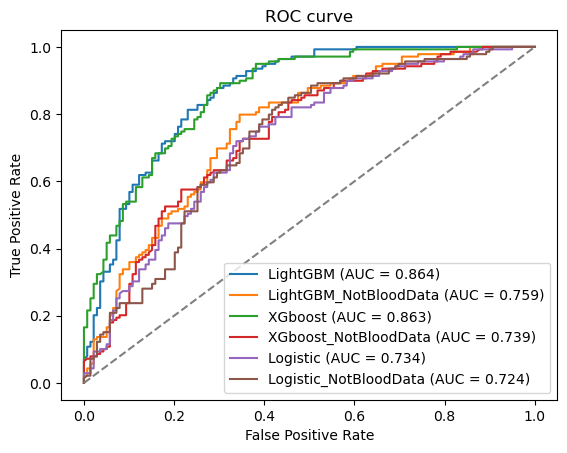

LightGBM AUCスコア = 0.864
XGboost AUCスコア = 0.863
Logistic AUCスコア = 0.734
LightGBM_notblood AUCスコア = 0.759
XGboost_notblood AUCスコア = 0.739
Logistic_notblood AUCスコア = 0.724


In [23]:
#ライブラリをインポート
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, roc_curve, roc_auc_score


# テストデータの予測確率を取得
y_test_pred_proba_light_not = model.predict(X_test_not)
y_test_pred_proba_xgb_not = model_xgb.predict(dtest_not)  # dtestはXGboost用のデータセット
y_test_pred_proba_lr_not = model_lr.predict_proba(X_test_lr_not)[:, 1]

# AUCスコアを計算
auc_score_light_not = roc_auc_score(y_test_not, y_test_pred_proba_light_not)
auc_score_xgb_not = roc_auc_score(y_test_not, y_test_pred_proba_xgb_not)
auc_score_lr_not = roc_auc_score(y_test_lr_not, y_test_pred_proba_lr_not)

# 以下省略




# AUC曲線をプロット_not
# lightGBMの描写
fpr_light, tpr_light, _ = roc_curve(y_test, y_test_pred_proba_light)
plt.plot(fpr_light, tpr_light, label='LightGBM (AUC = {:.3f})'.format(auc_score_light))

# lightGBM(血液データなし)の描写
fpr_light, tpr_light, _ = roc_curve(y_test_not, y_test_pred_proba_light_not)
plt.plot(fpr_light, tpr_light, label='LightGBM_NotBloodData (AUC = {:.3f})'.format(auc_score_light_not))


# XGboostの描写
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_test_pred_proba_xgb)
plt.plot(fpr_xgb, tpr_xgb, label='XGboost (AUC = {:.3f})'.format(auc_score_xgb))

# XGboost(血液データなし)の描写
fpr_xgb, tpr_xgb, _ = roc_curve(y_test_not, y_test_pred_proba_xgb_not)
plt.plot(fpr_xgb, tpr_xgb, label='XGboost_NotBloodData (AUC = {:.3f})'.format(auc_score_xgb_not))


# ロジスティック回帰の描写
fpr_lr, tpr_lr, _ = roc_curve(y_test_lr, y_test_pred_proba_lr)
plt.plot(fpr_lr, tpr_lr, label='Logistic (AUC = {:.3f})'.format(auc_score_lr))

# ロジスティック回帰(血液データなし)の描写
fpr_lr, tpr_lr, _ = roc_curve(y_test_lr_not, y_test_pred_proba_lr_not)
plt.plot(fpr_lr, tpr_lr, label='Logistic_NotBloodData (AUC = {:.3f})'.format(auc_score_lr_not))


plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend()

# 保存と表示
plt.savefig('roc_curve_notboold.png', dpi=300)
plt.show()

# AUCスコアを表示
print('LightGBM AUCスコア = {:.3f}'.format(auc_score_light))
print('XGboost AUCスコア = {:.3f}'.format(auc_score_xgb))
print('Logistic AUCスコア = {:.3f}'.format(auc_score_lr))
print('LightGBM_notblood AUCスコア = {:.3f}'.format(auc_score_light_not))
print('XGboost_notblood AUCスコア = {:.3f}'.format(auc_score_xgb_not))
print('Logistic_notblood AUCスコア = {:.3f}'.format(auc_score_lr_not))

## 特徴量抽出(Shap)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


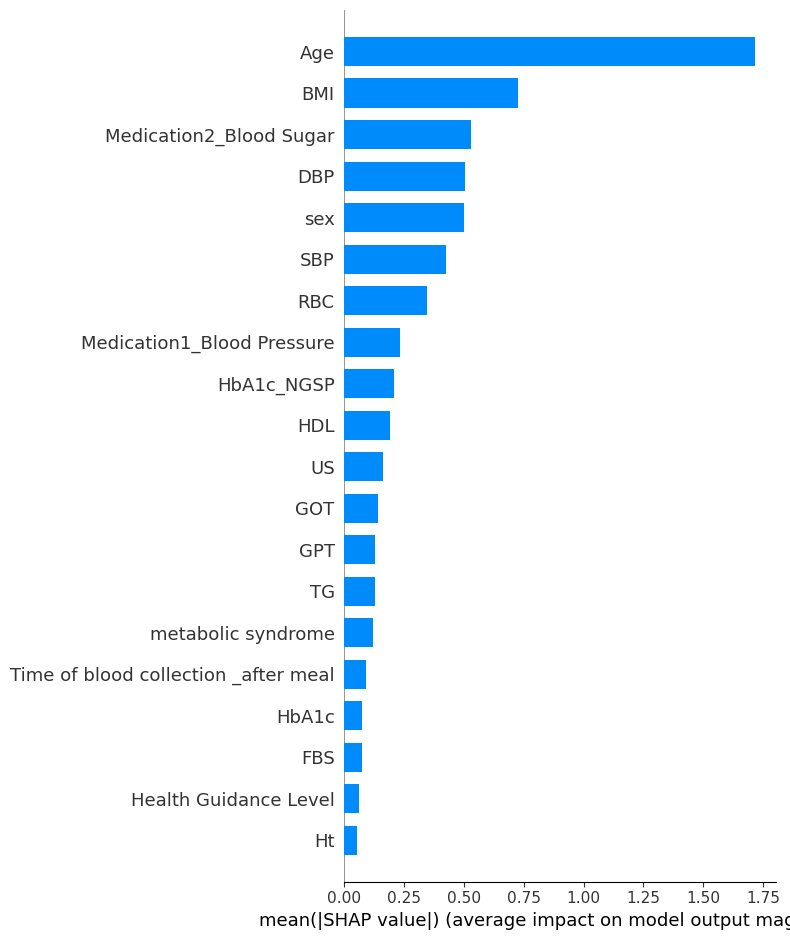

In [11]:
import shap

# SHAPの解釈子を作成
explainer = shap.TreeExplainer(model)

# テストデータのSHAP値を計算
shap_values = explainer.shap_values(X_test_not)

# SHAP summary plotを作成
shap.summary_plot(shap_values[1], X_test_not, feature_names=X_test.columns, plot_type="bar",show=False,)

# レイアウトの調整
plt.tight_layout()


# 保存
plt.savefig('summary_plot_lightgbm_notblood.png', dpi=300)


## 一貫して動くか検証

X_trainの形状： (646, 37)  y_trainの形状： (646,)  X_testの形状： (278, 37)  y_testの形状： (278,)
[1]	train's binary_logloss: 0.656312
Training until validation scores don't improve for 20 rounds
[2]	train's binary_logloss: 0.626316
[3]	train's binary_logloss: 0.601529
[4]	train's binary_logloss: 0.581017
[5]	train's binary_logloss: 0.563854
[6]	train's binary_logloss: 0.547673
[7]	train's binary_logloss: 0.533665
[8]	train's binary_logloss: 0.521808
[9]	train's binary_logloss: 0.50824
[10]	train's binary_logloss: 0.499083
[11]	train's binary_logloss: 0.49066
[12]	train's binary_logloss: 0.483647
[13]	train's binary_logloss: 0.475364
[14]	train's binary_logloss: 0.468928
[15]	train's binary_logloss: 0.460815
[16]	train's binary_logloss: 0.455492
[17]	train's binary_logloss: 0.45057
[18]	train's binary_logloss: 0.442056
[19]	train's binary_logloss: 0.436064
[20]	train's binary_logloss: 0.432305
[21]	train's binary_logloss: 0.425758
[22]	train's binary_logloss: 0.422075
[23]	train's binary_logloss: 0.4

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


X_trainの形状： (646, 37)  y_trainの形状： (646,)  X_testの形状： (278, 37)  y_testの形状： (278,)
[1]	train's binary_logloss: 0.656312
Training until validation scores don't improve for 20 rounds
[2]	train's binary_logloss: 0.626316
[3]	train's binary_logloss: 0.601529
[4]	train's binary_logloss: 0.581017
[5]	train's binary_logloss: 0.563854
[6]	train's binary_logloss: 0.547673
[7]	train's binary_logloss: 0.533665
[8]	train's binary_logloss: 0.521808
[9]	train's binary_logloss: 0.50824
[10]	train's binary_logloss: 0.499083
[11]	train's binary_logloss: 0.49066
[12]	train's binary_logloss: 0.483647
[13]	train's binary_logloss: 0.475364
[14]	train's binary_logloss: 0.468928
[15]	train's binary_logloss: 0.460815
[16]	train's binary_logloss: 0.455492
[17]	train's binary_logloss: 0.45057
[18]	train's binary_logloss: 0.442056
[19]	train's binary_logloss: 0.436064
[20]	train's binary_logloss: 0.432305
[21]	train's binary_logloss: 0.425758
[22]	train's binary_logloss: 0.422075
[23]	train's binary_logloss: 0.4

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


X_trainの形状： (646, 37)  y_trainの形状： (646,)  X_testの形状： (278, 37)  y_testの形状： (278,)
[1]	train's binary_logloss: 0.656312
Training until validation scores don't improve for 20 rounds
[2]	train's binary_logloss: 0.626316
[3]	train's binary_logloss: 0.601529
[4]	train's binary_logloss: 0.581017
[5]	train's binary_logloss: 0.563854
[6]	train's binary_logloss: 0.547673
[7]	train's binary_logloss: 0.533665
[8]	train's binary_logloss: 0.521808
[9]	train's binary_logloss: 0.50824
[10]	train's binary_logloss: 0.499083
[11]	train's binary_logloss: 0.49066
[12]	train's binary_logloss: 0.483647
[13]	train's binary_logloss: 0.475364
[14]	train's binary_logloss: 0.468928
[15]	train's binary_logloss: 0.460815
[16]	train's binary_logloss: 0.455492
[17]	train's binary_logloss: 0.45057
[18]	train's binary_logloss: 0.442056
[19]	train's binary_logloss: 0.436064
[20]	train's binary_logloss: 0.432305
[21]	train's binary_logloss: 0.425758
[22]	train's binary_logloss: 0.422075
[23]	train's binary_logloss: 0.4

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


X_trainの形状： (646, 37)  y_trainの形状： (646,)  X_testの形状： (278, 37)  y_testの形状： (278,)
[1]	train's binary_logloss: 0.656312
Training until validation scores don't improve for 20 rounds
[2]	train's binary_logloss: 0.626316
[3]	train's binary_logloss: 0.601529
[4]	train's binary_logloss: 0.581017
[5]	train's binary_logloss: 0.563854
[6]	train's binary_logloss: 0.547673
[7]	train's binary_logloss: 0.533665
[8]	train's binary_logloss: 0.521808
[9]	train's binary_logloss: 0.50824
[10]	train's binary_logloss: 0.499083
[11]	train's binary_logloss: 0.49066
[12]	train's binary_logloss: 0.483647
[13]	train's binary_logloss: 0.475364
[14]	train's binary_logloss: 0.468928
[15]	train's binary_logloss: 0.460815
[16]	train's binary_logloss: 0.455492
[17]	train's binary_logloss: 0.45057
[18]	train's binary_logloss: 0.442056
[19]	train's binary_logloss: 0.436064
[20]	train's binary_logloss: 0.432305
[21]	train's binary_logloss: 0.425758
[22]	train's binary_logloss: 0.422075
[23]	train's binary_logloss: 0.4

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


X_trainの形状： (646, 37)  y_trainの形状： (646,)  X_testの形状： (278, 37)  y_testの形状： (278,)
[1]	train's binary_logloss: 0.656312
Training until validation scores don't improve for 20 rounds
[2]	train's binary_logloss: 0.626316
[3]	train's binary_logloss: 0.601529
[4]	train's binary_logloss: 0.581017
[5]	train's binary_logloss: 0.563854
[6]	train's binary_logloss: 0.547673
[7]	train's binary_logloss: 0.533665
[8]	train's binary_logloss: 0.521808
[9]	train's binary_logloss: 0.50824
[10]	train's binary_logloss: 0.499083
[11]	train's binary_logloss: 0.49066
[12]	train's binary_logloss: 0.483647
[13]	train's binary_logloss: 0.475364
[14]	train's binary_logloss: 0.468928
[15]	train's binary_logloss: 0.460815
[16]	train's binary_logloss: 0.455492
[17]	train's binary_logloss: 0.45057
[18]	train's binary_logloss: 0.442056
[19]	train's binary_logloss: 0.436064
[20]	train's binary_logloss: 0.432305
[21]	train's binary_logloss: 0.425758
[22]	train's binary_logloss: 0.422075
[23]	train's binary_logloss: 0.4

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


X_trainの形状： (646, 37)  y_trainの形状： (646,)  X_testの形状： (278, 37)  y_testの形状： (278,)
[1]	train's binary_logloss: 0.656312
Training until validation scores don't improve for 20 rounds
[2]	train's binary_logloss: 0.626316
[3]	train's binary_logloss: 0.601529
[4]	train's binary_logloss: 0.581017
[5]	train's binary_logloss: 0.563854
[6]	train's binary_logloss: 0.547673
[7]	train's binary_logloss: 0.533665
[8]	train's binary_logloss: 0.521808
[9]	train's binary_logloss: 0.50824
[10]	train's binary_logloss: 0.499083
[11]	train's binary_logloss: 0.49066
[12]	train's binary_logloss: 0.483647
[13]	train's binary_logloss: 0.475364
[14]	train's binary_logloss: 0.468928
[15]	train's binary_logloss: 0.460815
[16]	train's binary_logloss: 0.455492
[17]	train's binary_logloss: 0.45057
[18]	train's binary_logloss: 0.442056
[19]	train's binary_logloss: 0.436064
[20]	train's binary_logloss: 0.432305
[21]	train's binary_logloss: 0.425758
[22]	train's binary_logloss: 0.422075
[23]	train's binary_logloss: 0.4

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


X_trainの形状： (646, 37)  y_trainの形状： (646,)  X_testの形状： (278, 37)  y_testの形状： (278,)
[1]	train's binary_logloss: 0.656312
Training until validation scores don't improve for 20 rounds
[2]	train's binary_logloss: 0.626316
[3]	train's binary_logloss: 0.601529
[4]	train's binary_logloss: 0.581017
[5]	train's binary_logloss: 0.563854
[6]	train's binary_logloss: 0.547673
[7]	train's binary_logloss: 0.533665
[8]	train's binary_logloss: 0.521808
[9]	train's binary_logloss: 0.50824
[10]	train's binary_logloss: 0.499083
[11]	train's binary_logloss: 0.49066
[12]	train's binary_logloss: 0.483647
[13]	train's binary_logloss: 0.475364
[14]	train's binary_logloss: 0.468928
[15]	train's binary_logloss: 0.460815
[16]	train's binary_logloss: 0.455492
[17]	train's binary_logloss: 0.45057
[18]	train's binary_logloss: 0.442056
[19]	train's binary_logloss: 0.436064
[20]	train's binary_logloss: 0.432305
[21]	train's binary_logloss: 0.425758
[22]	train's binary_logloss: 0.422075
[23]	train's binary_logloss: 0.4

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


X_trainの形状： (646, 37)  y_trainの形状： (646,)  X_testの形状： (278, 37)  y_testの形状： (278,)
[1]	train's binary_logloss: 0.656312
Training until validation scores don't improve for 20 rounds
[2]	train's binary_logloss: 0.626316
[3]	train's binary_logloss: 0.601529
[4]	train's binary_logloss: 0.581017
[5]	train's binary_logloss: 0.563854
[6]	train's binary_logloss: 0.547673
[7]	train's binary_logloss: 0.533665
[8]	train's binary_logloss: 0.521808
[9]	train's binary_logloss: 0.50824
[10]	train's binary_logloss: 0.499083
[11]	train's binary_logloss: 0.49066
[12]	train's binary_logloss: 0.483647
[13]	train's binary_logloss: 0.475364
[14]	train's binary_logloss: 0.468928
[15]	train's binary_logloss: 0.460815
[16]	train's binary_logloss: 0.455492
[17]	train's binary_logloss: 0.45057
[18]	train's binary_logloss: 0.442056
[19]	train's binary_logloss: 0.436064
[20]	train's binary_logloss: 0.432305
[21]	train's binary_logloss: 0.425758
[22]	train's binary_logloss: 0.422075
[23]	train's binary_logloss: 0.4

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


X_trainの形状： (646, 37)  y_trainの形状： (646,)  X_testの形状： (278, 37)  y_testの形状： (278,)
[1]	train's binary_logloss: 0.656312
Training until validation scores don't improve for 20 rounds
[2]	train's binary_logloss: 0.626316
[3]	train's binary_logloss: 0.601529
[4]	train's binary_logloss: 0.581017
[5]	train's binary_logloss: 0.563854
[6]	train's binary_logloss: 0.547673
[7]	train's binary_logloss: 0.533665
[8]	train's binary_logloss: 0.521808
[9]	train's binary_logloss: 0.50824
[10]	train's binary_logloss: 0.499083
[11]	train's binary_logloss: 0.49066
[12]	train's binary_logloss: 0.483647
[13]	train's binary_logloss: 0.475364
[14]	train's binary_logloss: 0.468928
[15]	train's binary_logloss: 0.460815
[16]	train's binary_logloss: 0.455492
[17]	train's binary_logloss: 0.45057
[18]	train's binary_logloss: 0.442056
[19]	train's binary_logloss: 0.436064
[20]	train's binary_logloss: 0.432305
[21]	train's binary_logloss: 0.425758
[22]	train's binary_logloss: 0.422075
[23]	train's binary_logloss: 0.4

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


X_trainの形状： (646, 37)  y_trainの形状： (646,)  X_testの形状： (278, 37)  y_testの形状： (278,)
[1]	train's binary_logloss: 0.656312
Training until validation scores don't improve for 20 rounds
[2]	train's binary_logloss: 0.626316
[3]	train's binary_logloss: 0.601529
[4]	train's binary_logloss: 0.581017
[5]	train's binary_logloss: 0.563854
[6]	train's binary_logloss: 0.547673
[7]	train's binary_logloss: 0.533665
[8]	train's binary_logloss: 0.521808
[9]	train's binary_logloss: 0.50824
[10]	train's binary_logloss: 0.499083
[11]	train's binary_logloss: 0.49066
[12]	train's binary_logloss: 0.483647
[13]	train's binary_logloss: 0.475364
[14]	train's binary_logloss: 0.468928
[15]	train's binary_logloss: 0.460815
[16]	train's binary_logloss: 0.455492
[17]	train's binary_logloss: 0.45057
[18]	train's binary_logloss: 0.442056
[19]	train's binary_logloss: 0.436064
[20]	train's binary_logloss: 0.432305
[21]	train's binary_logloss: 0.425758
[22]	train's binary_logloss: 0.422075
[23]	train's binary_logloss: 0.4

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


LightGBM accuracy = 0.77
LightGBM F1-score = 0.77
LightGBM Precision = 0.78
XGboost accuracy = 0.73
XGboost F1-score = 0.73
XGboost Precision = 0.74
Logistic Regression accuracy = 0.70
Logistic Regression F1-score = 0.70
Logistic Regression Precision = 0.71
X_trainの形状： (646, 24)  y_trainの形状： (646,)  X_testの形状： (278, 24)  y_testの形状： (278,)
[1]	train's binary_logloss: 0.662906
Training until validation scores don't improve for 20 rounds
[2]	train's binary_logloss: 0.638297
[3]	train's binary_logloss: 0.617479
[4]	train's binary_logloss: 0.600501
[5]	train's binary_logloss: 0.585878
[6]	train's binary_logloss: 0.573603
[7]	train's binary_logloss: 0.562965
[8]	train's binary_logloss: 0.553485
[9]	train's binary_logloss: 0.545568
[10]	train's binary_logloss: 0.538341
[11]	train's binary_logloss: 0.53218
[12]	train's binary_logloss: 0.526888
[13]	train's binary_logloss: 0.521507
[14]	train's binary_logloss: 0.516283
[15]	train's binary_logloss: 0.511686
[16]	train's binary_logloss: 0.507458


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


X_trainの形状： (646, 24)  y_trainの形状： (646,)  X_testの形状： (278, 24)  y_testの形状： (278,)
[1]	train's binary_logloss: 0.662906
Training until validation scores don't improve for 20 rounds
[2]	train's binary_logloss: 0.638297
[3]	train's binary_logloss: 0.617479
[4]	train's binary_logloss: 0.600501
[5]	train's binary_logloss: 0.585878
[6]	train's binary_logloss: 0.573603
[7]	train's binary_logloss: 0.562965
[8]	train's binary_logloss: 0.553485
[9]	train's binary_logloss: 0.545568
[10]	train's binary_logloss: 0.538341
[11]	train's binary_logloss: 0.53218
[12]	train's binary_logloss: 0.526888
[13]	train's binary_logloss: 0.521507
[14]	train's binary_logloss: 0.516283
[15]	train's binary_logloss: 0.511686
[16]	train's binary_logloss: 0.507458
[17]	train's binary_logloss: 0.502668
[18]	train's binary_logloss: 0.498687
[19]	train's binary_logloss: 0.494656
[20]	train's binary_logloss: 0.491561
[21]	train's binary_logloss: 0.488351
[22]	train's binary_logloss: 0.485573
[23]	train's binary_logloss: 0

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


X_trainの形状： (646, 24)  y_trainの形状： (646,)  X_testの形状： (278, 24)  y_testの形状： (278,)
[1]	train's binary_logloss: 0.662906
Training until validation scores don't improve for 20 rounds
[2]	train's binary_logloss: 0.638297
[3]	train's binary_logloss: 0.617479
[4]	train's binary_logloss: 0.600501
[5]	train's binary_logloss: 0.585878
[6]	train's binary_logloss: 0.573603
[7]	train's binary_logloss: 0.562965
[8]	train's binary_logloss: 0.553485
[9]	train's binary_logloss: 0.545568
[10]	train's binary_logloss: 0.538341
[11]	train's binary_logloss: 0.53218
[12]	train's binary_logloss: 0.526888
[13]	train's binary_logloss: 0.521507
[14]	train's binary_logloss: 0.516283
[15]	train's binary_logloss: 0.511686
[16]	train's binary_logloss: 0.507458
[17]	train's binary_logloss: 0.502668
[18]	train's binary_logloss: 0.498687
[19]	train's binary_logloss: 0.494656
[20]	train's binary_logloss: 0.491561
[21]	train's binary_logloss: 0.488351
[22]	train's binary_logloss: 0.485573
[23]	train's binary_logloss: 0

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


X_trainの形状： (646, 24)  y_trainの形状： (646,)  X_testの形状： (278, 24)  y_testの形状： (278,)
[1]	train's binary_logloss: 0.662906
Training until validation scores don't improve for 20 rounds
[2]	train's binary_logloss: 0.638297
[3]	train's binary_logloss: 0.617479
[4]	train's binary_logloss: 0.600501
[5]	train's binary_logloss: 0.585878
[6]	train's binary_logloss: 0.573603
[7]	train's binary_logloss: 0.562965
[8]	train's binary_logloss: 0.553485
[9]	train's binary_logloss: 0.545568
[10]	train's binary_logloss: 0.538341
[11]	train's binary_logloss: 0.53218
[12]	train's binary_logloss: 0.526888
[13]	train's binary_logloss: 0.521507
[14]	train's binary_logloss: 0.516283
[15]	train's binary_logloss: 0.511686
[16]	train's binary_logloss: 0.507458
[17]	train's binary_logloss: 0.502668
[18]	train's binary_logloss: 0.498687
[19]	train's binary_logloss: 0.494656
[20]	train's binary_logloss: 0.491561
[21]	train's binary_logloss: 0.488351
[22]	train's binary_logloss: 0.485573
[23]	train's binary_logloss: 0

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


X_trainの形状： (646, 24)  y_trainの形状： (646,)  X_testの形状： (278, 24)  y_testの形状： (278,)
[1]	train's binary_logloss: 0.662906
Training until validation scores don't improve for 20 rounds
[2]	train's binary_logloss: 0.638297
[3]	train's binary_logloss: 0.617479
[4]	train's binary_logloss: 0.600501
[5]	train's binary_logloss: 0.585878
[6]	train's binary_logloss: 0.573603
[7]	train's binary_logloss: 0.562965
[8]	train's binary_logloss: 0.553485
[9]	train's binary_logloss: 0.545568
[10]	train's binary_logloss: 0.538341
[11]	train's binary_logloss: 0.53218
[12]	train's binary_logloss: 0.526888
[13]	train's binary_logloss: 0.521507
[14]	train's binary_logloss: 0.516283
[15]	train's binary_logloss: 0.511686
[16]	train's binary_logloss: 0.507458
[17]	train's binary_logloss: 0.502668
[18]	train's binary_logloss: 0.498687
[19]	train's binary_logloss: 0.494656
[20]	train's binary_logloss: 0.491561
[21]	train's binary_logloss: 0.488351
[22]	train's binary_logloss: 0.485573
[23]	train's binary_logloss: 0

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


X_trainの形状： (646, 24)  y_trainの形状： (646,)  X_testの形状： (278, 24)  y_testの形状： (278,)
[1]	train's binary_logloss: 0.662906
Training until validation scores don't improve for 20 rounds
[2]	train's binary_logloss: 0.638297
[3]	train's binary_logloss: 0.617479
[4]	train's binary_logloss: 0.600501
[5]	train's binary_logloss: 0.585878
[6]	train's binary_logloss: 0.573603
[7]	train's binary_logloss: 0.562965
[8]	train's binary_logloss: 0.553485
[9]	train's binary_logloss: 0.545568
[10]	train's binary_logloss: 0.538341
[11]	train's binary_logloss: 0.53218
[12]	train's binary_logloss: 0.526888
[13]	train's binary_logloss: 0.521507
[14]	train's binary_logloss: 0.516283
[15]	train's binary_logloss: 0.511686
[16]	train's binary_logloss: 0.507458
[17]	train's binary_logloss: 0.502668
[18]	train's binary_logloss: 0.498687
[19]	train's binary_logloss: 0.494656
[20]	train's binary_logloss: 0.491561
[21]	train's binary_logloss: 0.488351
[22]	train's binary_logloss: 0.485573
[23]	train's binary_logloss: 0

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


X_trainの形状： (646, 24)  y_trainの形状： (646,)  X_testの形状： (278, 24)  y_testの形状： (278,)
[1]	train's binary_logloss: 0.662906
Training until validation scores don't improve for 20 rounds
[2]	train's binary_logloss: 0.638297
[3]	train's binary_logloss: 0.617479
[4]	train's binary_logloss: 0.600501
[5]	train's binary_logloss: 0.585878
[6]	train's binary_logloss: 0.573603
[7]	train's binary_logloss: 0.562965
[8]	train's binary_logloss: 0.553485
[9]	train's binary_logloss: 0.545568
[10]	train's binary_logloss: 0.538341
[11]	train's binary_logloss: 0.53218
[12]	train's binary_logloss: 0.526888
[13]	train's binary_logloss: 0.521507
[14]	train's binary_logloss: 0.516283
[15]	train's binary_logloss: 0.511686
[16]	train's binary_logloss: 0.507458
[17]	train's binary_logloss: 0.502668
[18]	train's binary_logloss: 0.498687
[19]	train's binary_logloss: 0.494656
[20]	train's binary_logloss: 0.491561
[21]	train's binary_logloss: 0.488351
[22]	train's binary_logloss: 0.485573
[23]	train's binary_logloss: 0

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


X_trainの形状： (646, 24)  y_trainの形状： (646,)  X_testの形状： (278, 24)  y_testの形状： (278,)
[1]	train's binary_logloss: 0.662906
Training until validation scores don't improve for 20 rounds
[2]	train's binary_logloss: 0.638297
[3]	train's binary_logloss: 0.617479
[4]	train's binary_logloss: 0.600501
[5]	train's binary_logloss: 0.585878
[6]	train's binary_logloss: 0.573603
[7]	train's binary_logloss: 0.562965
[8]	train's binary_logloss: 0.553485
[9]	train's binary_logloss: 0.545568
[10]	train's binary_logloss: 0.538341
[11]	train's binary_logloss: 0.53218
[12]	train's binary_logloss: 0.526888
[13]	train's binary_logloss: 0.521507
[14]	train's binary_logloss: 0.516283
[15]	train's binary_logloss: 0.511686
[16]	train's binary_logloss: 0.507458
[17]	train's binary_logloss: 0.502668
[18]	train's binary_logloss: 0.498687
[19]	train's binary_logloss: 0.494656
[20]	train's binary_logloss: 0.491561
[21]	train's binary_logloss: 0.488351
[22]	train's binary_logloss: 0.485573
[23]	train's binary_logloss: 0

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


X_trainの形状： (646, 24)  y_trainの形状： (646,)  X_testの形状： (278, 24)  y_testの形状： (278,)
[1]	train's binary_logloss: 0.662906
Training until validation scores don't improve for 20 rounds
[2]	train's binary_logloss: 0.638297
[3]	train's binary_logloss: 0.617479
[4]	train's binary_logloss: 0.600501
[5]	train's binary_logloss: 0.585878
[6]	train's binary_logloss: 0.573603
[7]	train's binary_logloss: 0.562965
[8]	train's binary_logloss: 0.553485
[9]	train's binary_logloss: 0.545568
[10]	train's binary_logloss: 0.538341
[11]	train's binary_logloss: 0.53218
[12]	train's binary_logloss: 0.526888
[13]	train's binary_logloss: 0.521507
[14]	train's binary_logloss: 0.516283
[15]	train's binary_logloss: 0.511686
[16]	train's binary_logloss: 0.507458
[17]	train's binary_logloss: 0.502668
[18]	train's binary_logloss: 0.498687
[19]	train's binary_logloss: 0.494656
[20]	train's binary_logloss: 0.491561
[21]	train's binary_logloss: 0.488351
[22]	train's binary_logloss: 0.485573
[23]	train's binary_logloss: 0

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


X_trainの形状： (646, 24)  y_trainの形状： (646,)  X_testの形状： (278, 24)  y_testの形状： (278,)
[1]	train's binary_logloss: 0.662906
Training until validation scores don't improve for 20 rounds
[2]	train's binary_logloss: 0.638297
[3]	train's binary_logloss: 0.617479
[4]	train's binary_logloss: 0.600501
[5]	train's binary_logloss: 0.585878
[6]	train's binary_logloss: 0.573603
[7]	train's binary_logloss: 0.562965
[8]	train's binary_logloss: 0.553485
[9]	train's binary_logloss: 0.545568
[10]	train's binary_logloss: 0.538341
[11]	train's binary_logloss: 0.53218
[12]	train's binary_logloss: 0.526888
[13]	train's binary_logloss: 0.521507
[14]	train's binary_logloss: 0.516283
[15]	train's binary_logloss: 0.511686
[16]	train's binary_logloss: 0.507458
[17]	train's binary_logloss: 0.502668
[18]	train's binary_logloss: 0.498687
[19]	train's binary_logloss: 0.494656
[20]	train's binary_logloss: 0.491561
[21]	train's binary_logloss: 0.488351
[22]	train's binary_logloss: 0.485573
[23]	train's binary_logloss: 0

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


LightGBM_notblood accuracy = 0.69
LightGBM_notblood F1-score = 0.69
LightGBM_notblood Precision = 0.69
XGboost_notblood accuracy = 0.68
XGboost_notblood F1-score = 0.69
XGboost_notblood Precision = 0.68
Logistic_notblood Regression accuracy = 0.65
Logistic_notblood Regression F1-score = 0.64
Logistic_notblood Regression Precision = 0.66


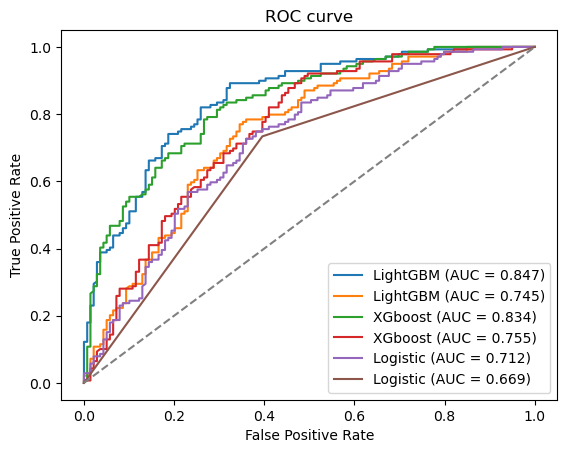

LightGBM AUCスコア = 0.847
XGboost AUCスコア = 0.834
Logistic AUCスコア = 0.712
LightGBM_notblood AUCスコア = 0.745
XGboost_notblood AUCスコア = 0.755
Logistic_notblood AUCスコア = 0.669


In [22]:
# ライブラリのインポート
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score
from sklearn.utils import class_weight
from sklearn.ensemble import BaggingClassifier
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb  #lightGBMを入れる
import xgboost as xgb  #XGboostを入れる
from sklearn.linear_model import LogisticRegression  # ロジスティック回帰を入れる
import shap

# データの読み込み
df = pd.read_excel('【元データ】LightGBM分析データ_欠損値処理.xlsx')
df_lr = pd.read_excel('補完データ02_test03.xlsx') #　ロジスティック回帰のデータ読み込み

# カテゴリ変数のデータ型を変換
cat_cols = ['FBS', 'HbA1c', 'US', 'HbA1c_NGSP']
df[cat_cols] = df[cat_cols].astype(str)
df_lr[cat_cols] = df_lr[cat_cols].astype(str)


# ラベルエンコーディングを実行
le = LabelEncoder()
df[cat_cols] = df[cat_cols].apply(le.fit_transform)
df_lr[cat_cols] = df_lr[cat_cols].apply(le.fit_transform)



# 特徴量とターゲットに分割
X = df.drop('T2db', axis=1)
y = df['T2db']

X_lr = df_lr.drop('T2db', axis=1)
y_lr = df_lr['T2db']

# 特定の列を削除（欠損値が多いため）
df = df.drop(['Ht', 'Hb', 'RBC', 'Time of blood collection _after meal', 'Eating style3_midnight snack', 'One-year weight change'], axis=1)
df_lr = df_lr.drop(['Ht', 'Hb', 'RBC', 'Time of blood collection _after meal', 'Eating style3_midnight snack', 'One-year weight change'], axis=1)

# 削除した結果を反映した特徴量を再作成
X = df.drop('T2db', axis=1)
X_lr = df_lr.drop('T2db', axis=1)

# アンダーサンプリング
rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(X, y)
X_resampled_lr, y_resampled_lr = rus.fit_resample(X_lr, y_lr)

# バギングによるモデルの学習と評価
# lightGBM
accuracy_scores = []
f1_scores = []
precision_scores = []  # 適合率を格納するリスト
confusion_matrices = []

# XGboost
accuracy_scores_xgb = []
f1_scores_xgb = []
precision_scores_xgb = []  # 適合率を格納するリスト
confusion_matrices_xgb = []

# ロジスティック回帰
accuracy_scores_lr = []
f1_scores_lr = []
precision_scores_lr = []  # 適合率を格納するリスト
confusion_matrices_lr = []
auc_scores_lr = []

n_estimators = 10  # バギングの回数

for _ in range(n_estimators):
    # 学習データとテストデータに分割
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, shuffle=True, stratify=y_resampled, random_state=0)
    print('X_trainの形状：', X_train.shape, ' y_trainの形状：', y_train.shape, ' X_testの形状：', X_test.shape, ' y_testの形状：', y_test.shape)
    
    # 学習データとテストデータに分割（ロジスティック回帰）
    X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X_resampled_lr, y_resampled_lr, test_size=0.3, shuffle=True, stratify=y_resampled, random_state=0)

    # LightGBM用のデータセットを作成
    lgb_train = lgb.Dataset(X_train, y_train)

    # xgboost用のデータセットを作成
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    # ハイパーパラメータの設定
    params = {
        'objective': 'binary',
        'num_leaves': 5,
        'seed': 0,
        'verbose': -1,
    }

    params_xgb = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'max_depth': 2,
        'learning_rate': 0.8,
        'base_score': 0.5,
        'min_split_loss': 0,
        'reg_lambda': 0,
        'reg_alpha': 0,
        'seed': 0,
    }

    # LightGBMモデルの学習
    model = lgb.train(params,
                      lgb_train,
                      num_boost_round=500,
                      valid_sets=[lgb_train],
                      valid_names=['train'],
                      early_stopping_rounds=20)

    # xgboostモデルの学習
    model_xgb = xgb.train(params_xgb,
                          dtrain,
                          num_boost_round=500,
                          early_stopping_rounds=20,
                          evals=[(dtest, 'test')])
    
    # ロジスティック回帰の学習
    model_lr = LogisticRegression()
    model_lr.fit(X_train_lr, y_train_lr)
    

    # テストデータの予測と評価(lightGBM)
    y_test_pred_proba = model.predict(X_test)  # ラベル1の確率
    y_test_pred = np.round(y_test_pred_proba)  # 確率をラベル0 or 1に変換
    ac_score = accuracy_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred)  # 適合率の計算

    # 混同行列(lightGBM)
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 20})
    plt.xlabel('pred')
    plt.ylabel('label')
    plt.savefig('confusion_matrix.png', dpi=300)
    plt.close()
    accuracy_scores.append(ac_score)
    f1_scores.append(f1)
    precision_scores.append(precision)  # 適合率
    confusion_matrices.append(cm)

    #テストデータの予測と評価(XGboost)
    y_test_pred_proba_xgb = model_xgb.predict(dtest)  # ラベル1の確率
    y_test_pred_xgb = np.round(y_test_pred_proba_xgb)  # 確率をラベル0 or 1に変換
    ac_score_xgb = accuracy_score(y_test, y_test_pred_xgb)
    f1_xgb = f1_score(y_test, y_test_pred_xgb)
    precision_xgb = precision_score(y_test, y_test_pred_xgb)  # 適合率の計算

    
    # 混同行列(XGboost)
    cm_xgb = confusion_matrix(y_test, y_test_pred_xgb)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 20})
    plt.xlabel('pred')
    plt.ylabel('label')
    plt.savefig('confusion_matrix_xgb.png', dpi=300)
    plt.close()
    accuracy_scores_xgb.append(ac_score_xgb)
    f1_scores_xgb.append(f1_xgb)
    precision_scores_xgb.append(precision_xgb)  # 適合率
    confusion_matrices_xgb.append(cm_xgb)
    
    
    #ロジスティック回帰による予測と評価
    y_test_pred_proba_lr = model.predict(X_test_lr)  # ラベル1の確率
    y_test_pred_lr = np.round(y_test_pred_proba_lr)  # 確率をラベル0 or 1に変換
    ac_score_lr = accuracy_score(y_test_lr, y_test_pred_lr)
    f1_lr = f1_score(y_test_lr, y_test_pred_lr)
    precision_lr = precision_score(y_test_lr, y_test_pred_lr)  # 適合率の計算

    # 混同行列(ロジスティック回帰)
    cm_lr = confusion_matrix(y_test_lr, y_test_pred_lr)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 20})
    plt.xlabel('pred')
    plt.ylabel('label')
    plt.savefig('confusion_matrix_lr.png', dpi=300)
    plt.close()
    accuracy_scores_lr.append(ac_score_lr)
    f1_scores_lr.append(f1_lr)
    precision_scores_lr.append(precision_lr)  # 適合率
    confusion_matrices_lr.append(cm_lr)
    

# 結果の表示
print('LightGBM accuracy = %.2f' % np.mean(accuracy_scores))
print('LightGBM F1-score = %.2f' % np.mean(f1_scores))
print('LightGBM Precision = %.2f' % np.mean(precision_scores))
# print('LightGBM AUC = %.2f' % np.mean(auc_scores))

print('XGboost accuracy = %.2f' % np.mean(accuracy_scores_xgb))
print('XGboost F1-score = %.2f' % np.mean(f1_scores_xgb))
print('XGboost Precision = %.2f' % np.mean(precision_scores_xgb))
# print('XGboost AUC = %.2f' % np.mean(auc_scores_xgb))

print('Logistic Regression accuracy = %.2f' % np.mean(accuracy_scores_lr))
print('Logistic Regression F1-score = %.2f' % np.mean(f1_scores_lr))
print('Logistic Regression Precision = %.2f' % np.mean(precision_scores_lr))
# print('Logistic Regression AUC = %.2f' % np.mean(auc_scores_lr))



#血圧データなしモデル作成

# データの読み込み
df = pd.read_excel('【元データ】LightGBM分析データ_欠損値処理.xlsx')
df_lr = pd.read_excel('補完データ02_test03.xlsx') #　ロジスティック回帰のデータ読み込み

# カテゴリ変数のデータ型を変換
cat_cols = ['FBS', 'HbA1c', 'US', 'HbA1c_NGSP']
df[cat_cols] = df[cat_cols].astype(str)
df_lr[cat_cols] = df_lr[cat_cols].astype(str)


# ラベルエンコーディングを実行
le = LabelEncoder()
df[cat_cols] = df[cat_cols].apply(le.fit_transform)
df_lr[cat_cols] = df_lr[cat_cols].apply(le.fit_transform)


# 特徴量とターゲットに分割
X = df.drop('T2db', axis=1)
y = df['T2db']

X_lr = df_lr.drop('T2db', axis=1)
y_lr = df_lr['T2db']

# 特定の列を削除
df = df.drop(['TG', 'HDL', 'LDL', 'GOT', 'GPT', 'γ_GT', 'Ht', 'Hb', 'RBC', 'chewing', 'Medication1_Blood Pressure', 'Time of blood collection _after meal', 'Medication2_Blood Sugar', 'Eating style3_midnight snack', 'One-year weight change', 'HbA1c', 'FBS', 'US', 'HbA1c_NGSP'], axis=1)
df_lr = df_lr.drop(['TG', 'HDL', 'LDL', 'GOT', 'GPT', 'γ_GT', 'Ht', 'Hb', 'RBC', 'chewing', 'Medication1_Blood Pressure', 'Time of blood collection _after meal', 'Medication2_Blood Sugar', 'Eating style3_midnight snack', 'One-year weight change', 'HbA1c', 'FBS', 'US', 'HbA1c_NGSP'], axis=1)

# 削除した結果を反映した特徴量を再作成
X = df.drop('T2db', axis=1)
X_lr = df_lr.drop('T2db', axis=1)

# アンダーサンプリング
rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(X, y)
X_resampled_lr, y_resampled_lr = rus.fit_resample(X_lr, y_lr)

# バギングによるモデルの学習と評価
# lightGBM
accuracy_scores_not = []
f1_scores_not = []
precision_scores_not = []  # 適合率を格納するリスト
confusion_matrices_not = []

# XGboost
accuracy_scores_xgb_not = []
f1_scores_xgb_not = []
precision_scores_xgb_not = []  # 適合率を格納するリスト
confusion_matrices_xgb_not = []

# ロジスティック回帰
accuracy_scores_lr_not = []
f1_scores_lr_not = []
precision_scores_lr_not = []  # 適合率を格納するリスト
confusion_matrices_lr_not = []
auc_scores_lr_not = []

n_estimators = 10  # バギングの回数

for _ in range(n_estimators):
    # 学習データとテストデータに分割
    X_train_not, X_test_not, y_train_not, y_test_not = train_test_split(X_resampled, y_resampled, test_size=0.3, shuffle=True, stratify=y_resampled, random_state=0)
    print('X_trainの形状：', X_train_not.shape, ' y_trainの形状：', y_train_not.shape, ' X_testの形状：', X_test_not.shape, ' y_testの形状：', y_test_not.shape)
    
    # 学習データとテストデータに分割（ロジスティック回帰）
    X_train_lr_not, X_test_lr_not, y_train_lr_not, y_test_lr_not = train_test_split(X_resampled_lr, y_resampled_lr, test_size=0.3, shuffle=True, stratify=y_resampled, random_state=0)

    # LightGBM用のデータセットを作成
    lgb_train = lgb.Dataset(X_train_not, y_train_not)

    # xgboost用のデータセットを作成
    dtrain_not = xgb.DMatrix(X_train_not, label=y_train_not)
    dtest_not = xgb.DMatrix(X_test_not, label=y_test_not)

    # ハイパーパラメータの設定
    params = {
        'objective': 'binary',
        'num_leaves': 5,
        'seed': 0,
        'verbose': -1,
    }

    params_xgb = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'max_depth': 2,
        'learning_rate': 0.8,
        'base_score': 0.5,
        'min_split_loss': 0,
        'reg_lambda': 0,
        'reg_alpha': 0,
        'seed': 0,
    }

    # LightGBMモデルの学習
    model = lgb.train(params,
                      lgb_train,
                      num_boost_round=500,
                      valid_sets=[lgb_train],
                      valid_names=['train'],
                      early_stopping_rounds=20)

    # xgboostモデルの学習
    model_xgb = xgb.train(params_xgb,
                          dtrain_not,
                          num_boost_round=500,
                          early_stopping_rounds=20,
                          evals=[(dtest_not, 'test')])
    
    # ロジスティック回帰の学習
    model_lr = LogisticRegression()
    model_lr.fit(X_train_lr_not, y_train_lr_not)
    

    # テストデータの予測と評価(lightGBM)
    y_test_pred_proba = model.predict(X_test_not)  # ラベル1の確率
    y_test_pred = np.round(y_test_pred_proba)  # 確率をラベル0 or 1に変換
    ac_score_not = accuracy_score(y_test_not, y_test_pred)
    f1_not = f1_score(y_test_not, y_test_pred)
    precision_not = precision_score(y_test_not, y_test_pred)  # 適合率の計算

    # 混同行列(lightGBM)
    cm = confusion_matrix(y_test_not, y_test_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 20})
    plt.xlabel('pred')
    plt.ylabel('label')
    plt.savefig('confusion_matrix_not.png', dpi=300)
    plt.close()
    accuracy_scores_not.append(ac_score_not)
    f1_scores_not.append(f1_not)
    precision_scores_not.append(precision_not)  # 適合率
    confusion_matrices_not.append(cm)

    # XGboostモデルのテストデータの予測と評価
    y_test_pred_proba_xgb_not = model_xgb.predict(dtest_not)  # ラベル1の確率
    y_test_pred_xgb_not = np.round(y_test_pred_proba_xgb_not)  # 確率をラベル0 or 1に変換
    ac_score_xgb_not = accuracy_score(y_test_not, y_test_pred_xgb_not)
    f1_xgb_not = f1_score(y_test_not, y_test_pred_xgb_not)
    precision_xgb_not = precision_score(y_test_not, y_test_pred_xgb_not)  # 適合率の計算
    
    # 混同行列(XGboost)
    cm_xgb = confusion_matrix(y_test_not, y_test_pred_xgb_not)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 20})
    plt.xlabel('pred')
    plt.ylabel('label')
    plt.savefig('confusion_matrix_xgb_not.png', dpi=300)
    plt.close()
    accuracy_scores_xgb_not.append(ac_score_xgb_not)
    f1_scores_xgb_not.append(f1_xgb_not)
    precision_scores_xgb_not.append(precision_xgb_not)  # 適合率
    confusion_matrices_xgb_not.append(cm_xgb)
    
    
    #ロジスティック回帰による予測と評価
    y_test_pred_proba_lr = model.predict(X_test_lr_not)  # ラベル1の確率
    y_test_pred_lr = np.round(y_test_pred_proba_lr)  # 確率をラベル0 or 1に変換
    ac_score_lr_not = accuracy_score(y_test_lr_not, y_test_pred_lr)
    f1_lr_not = f1_score(y_test_lr_not, y_test_pred_lr)
    precision_lr_not = precision_score(y_test_lr_not, y_test_pred_lr)  # 適合率の計算

    # 混同行列(ロジスティック回帰)
    cm_lr = confusion_matrix(y_test_lr_not, y_test_pred_lr)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 20})
    plt.xlabel('pred')
    plt.ylabel('label')
    plt.savefig('confusion_matrix_lr_not.png', dpi=300)
    plt.close()
    accuracy_scores_lr_not.append(ac_score_lr_not)
    f1_scores_lr_not.append(f1_lr_not)
    precision_scores_lr_not.append(precision_lr_not)  # 適合率
    confusion_matrices_lr_not.append(cm_lr)
    

# 結果の表示
print('LightGBM_notblood accuracy = %.2f' % np.mean(accuracy_scores_not))
print('LightGBM_notblood F1-score = %.2f' % np.mean(f1_scores_not))
print('LightGBM_notblood Precision = %.2f' % np.mean(precision_scores_not))
# print('LightGBM AUC = %.2f' % np.mean(auc_scores))

print('XGboost_notblood accuracy = %.2f' % np.mean(accuracy_scores_xgb_not))
print('XGboost_notblood F1-score = %.2f' % np.mean(f1_scores_xgb_not))
print('XGboost_notblood Precision = %.2f' % np.mean(precision_scores_xgb_not))
# print('XGboost AUC = %.2f' % np.mean(auc_scores_xgb))

print('Logistic_notblood Regression accuracy = %.2f' % np.mean(accuracy_scores_lr_not))
print('Logistic_notblood Regression F1-score = %.2f' % np.mean(f1_scores_lr_not))
print('Logistic_notblood Regression Precision = %.2f' % np.mean(precision_scores_lr_not))
# print('Logistic Regression AUC = %.2f' % np.mean(auc_scores_lr))

#ライブラリをインポート
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, roc_curve, roc_auc_score


# テストデータの予測確率を取得
y_test_pred_proba_light_not = model.predict(X_test_not)
y_test_pred_proba_xgb_not = model_xgb.predict(dtest_not)  # dtestはXGboost用のデータセット
y_test_pred_proba_lr_not = model_lr.predict(X_test_lr_not)

# AUCスコアを計算
auc_score_light_not = roc_auc_score(y_test_not, y_test_pred_proba_light_not)
auc_score_xgb_not = roc_auc_score(y_test_not, y_test_pred_proba_xgb_not)
auc_score_lr_not = roc_auc_score(y_test_lr_not, y_test_pred_proba_lr_not)



# AUC曲線をプロット_not
# lightGBMの描写
fpr_light, tpr_light, _ = roc_curve(y_test, y_test_pred_proba_light)
plt.plot(fpr_light, tpr_light, label='LightGBM (AUC = {:.3f})'.format(auc_score_light))

# lightGBM(血液データなし)の描写
fpr_light, tpr_light, _ = roc_curve(y_test_not, y_test_pred_proba_light_not)
plt.plot(fpr_light, tpr_light, label='LightGBM (AUC = {:.3f})'.format(auc_score_light_not))


# XGboostの描写
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_test_pred_proba_xgb)
plt.plot(fpr_xgb, tpr_xgb, label='XGboost (AUC = {:.3f})'.format(auc_score_xgb))

# XGboost(血液データなし)の描写
fpr_xgb, tpr_xgb, _ = roc_curve(y_test_not, y_test_pred_proba_xgb_not)
plt.plot(fpr_xgb, tpr_xgb, label='XGboost (AUC = {:.3f})'.format(auc_score_xgb_not))


# ロジスティック回帰の描写
fpr_lr, tpr_lr, _ = roc_curve(y_test_lr, y_test_pred_proba_lr)
plt.plot(fpr_lr, tpr_lr, label='Logistic (AUC = {:.3f})'.format(auc_score_lr))

# ロジスティック回帰(血液データなし)の描写
fpr_lr, tpr_lr, _ = roc_curve(y_test_lr_not, y_test_pred_proba_lr_not)
plt.plot(fpr_lr, tpr_lr, label='Logistic (AUC = {:.3f})'.format(auc_score_lr_not))


plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend()

# 保存と表示
plt.savefig('roc_curve_notboold.png', dpi=300)
plt.show()

# AUCスコアを表示
print('LightGBM AUCスコア = {:.3f}'.format(auc_score_light))
print('XGboost AUCスコア = {:.3f}'.format(auc_score_xgb))
print('Logistic AUCスコア = {:.3f}'.format(auc_score_lr))
print('LightGBM_notblood AUCスコア = {:.3f}'.format(auc_score_light_not))
print('XGboost_notblood AUCスコア = {:.3f}'.format(auc_score_xgb_not))
print('Logistic_notblood AUCスコア = {:.3f}'.format(auc_score_lr_not))